In [109]:
## Import Libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import StringIO

In [110]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [111]:
download_link = 'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data'
# see https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6
# new source https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

In [94]:
req = requests.get(download_link)
rki_raw = pd.read_csv(StringIO(req.text))

In [95]:
rki_raw.tail()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
150036,12243126,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2020/06/09 00:00:00,16077,"14.06.2020, 00:00 Uhr",0,-9,2020/05/19 00:00:00,0,1,1,Nicht übermittelt
150037,12243127,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2020/05/06 00:00:00,16077,"14.06.2020, 00:00 Uhr",0,-9,2020/05/04 00:00:00,0,1,1,Nicht übermittelt
150038,12243128,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2020/05/11 00:00:00,16077,"14.06.2020, 00:00 Uhr",0,-9,2020/05/01 00:00:00,0,1,1,Nicht übermittelt
150039,12243129,16,Thüringen,LK Altenburger Land,A80+,W,2,0,2020/05/28 00:00:00,16077,"14.06.2020, 00:00 Uhr",0,-9,2020/05/28 00:00:00,0,2,0,Nicht übermittelt
150040,12243130,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2020/06/09 00:00:00,16077,"14.06.2020, 00:00 Uhr",0,-9,2020/06/09 00:00:00,-9,0,0,Nicht übermittelt


In [96]:
def new_cases_by_date(rki_raw, rki_flag_column='Neuer Fall', rki_count_columns='AnzahlFall'):
    """
    rki_raw: raw DataFrame from Robert Koch Institute
    """
    condition = rki_raw[rki_flag_column].isin((0, 1))
    rki_series = rki_raw[condition].groupby('Meldedatum').sum()[rki_count_columns].copy()
    rki_series.index = pd.to_datetime(rki_series.index)
    rki_series.sort_index(inplace=True)
    return rki_series

In [97]:
rki_cases = new_cases_by_date(rki_raw, rki_flag_column='NeuerFall', rki_count_columns='AnzahlFall')
rki_death = new_cases_by_date(rki_raw, rki_flag_column='NeuerTodesfall', rki_count_columns='AnzahlTodesfall')
rki_recovered = new_cases_by_date(rki_raw, rki_flag_column='NeuGenesen', rki_count_columns='AnzahlGenesen')

In [98]:
rki = pd.concat([rki_cases, rki_death, rki_recovered], axis=1, sort=True)
columns_dict = {'AnzahlFall': 'NewCases', 'AnzahlTodesfall': 'NewDeathRKI', 'AnzahlGenesen': 'NewRecoveredRKI'}
rki.rename(columns_dict, axis=1, inplace=True)
# using estimates for recovery dates and death dates
shift_recovery = 14 # days
shift_death = 20 # days
rki['NewRecovered'] = rki.NewRecoveredRKI.shift(shift_recovery).fillna(0)
rki['NewDeath'] = rki.NewDeathRKI.shift(shift_death).fillna(0)
s = rki['NewRecoveredRKI'].copy()
s.values[:-shift_recovery] = 0.
rki['NewRecovered'] += s
s = rki['NewDeathRKI'].copy()
s.values[:-shift_death] = 0.
rki['NewDeath'] += s
rki.fillna(value=0., inplace=True)
rki.tail()

,NewCases,NewDeathRKI,NewRecoveredRKI,NewRecovered,NewDeath
Meldedatum,,,,,
2020-06-09,423,0.0,20,489.0,0.0
2020-06-10,496,1.0,17,492.0,7.0
2020-06-11,259,0.0,5,391.0,0.0
2020-06-12,272,2.0,7,333.0,11.0
2020-06-13,147,0.0,2,248.0,0.0


In [99]:
rki['Cases'] = rki['NewCases'].cumsum()
rki['Death'] = rki['NewDeath'].cumsum()
rki['Recovered'] = rki['NewRecovered'].cumsum()
rki['ActiveCases'] = rki['Cases'] - rki['Recovered'] - rki['Death']
rki['Growth'] = rki['NewCases'] / rki['ActiveCases']
rki.tail(10)

,NewCases,NewDeathRKI,NewRecoveredRKI,NewRecovered,NewDeath,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,,,
2020-06-04,528,4.0,120,426.0,30.0,183494,8663.0,169014.0,5817.0,0.090768
2020-06-05,440,2.0,57,481.0,19.0,183934,8682.0,169495.0,5757.0,0.076429
2020-06-06,282,2.0,29,288.0,8.0,184216,8690.0,169783.0,5743.0,0.049103
2020-06-07,163,0.0,24,167.0,0.0,184379,8690.0,169950.0,5739.0,0.028402
2020-06-08,293,2.0,21,305.0,27.0,184672,8717.0,170255.0,5700.0,0.051404
2020-06-09,423,0.0,20,489.0,0.0,185095,8717.0,170744.0,5634.0,0.075080
2020-06-10,496,1.0,17,492.0,7.0,185591,8724.0,171236.0,5631.0,0.088084
2020-06-11,259,0.0,5,391.0,0.0,185850,8724.0,171627.0,5499.0,0.047099
2020-06-12,272,2.0,7,333.0,11.0,186122,8735.0,171960.0,5427.0,0.050120


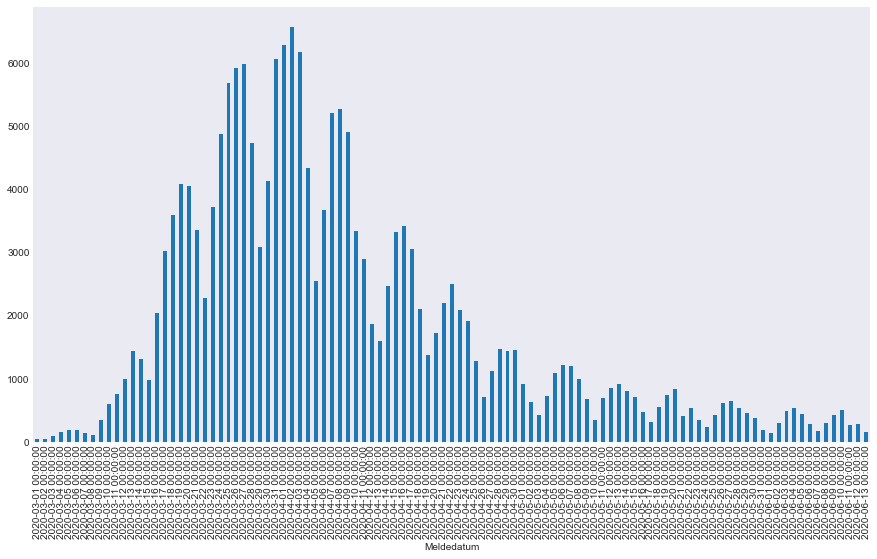

In [100]:
rki.NewCases['03-01-2020':].plot.bar()

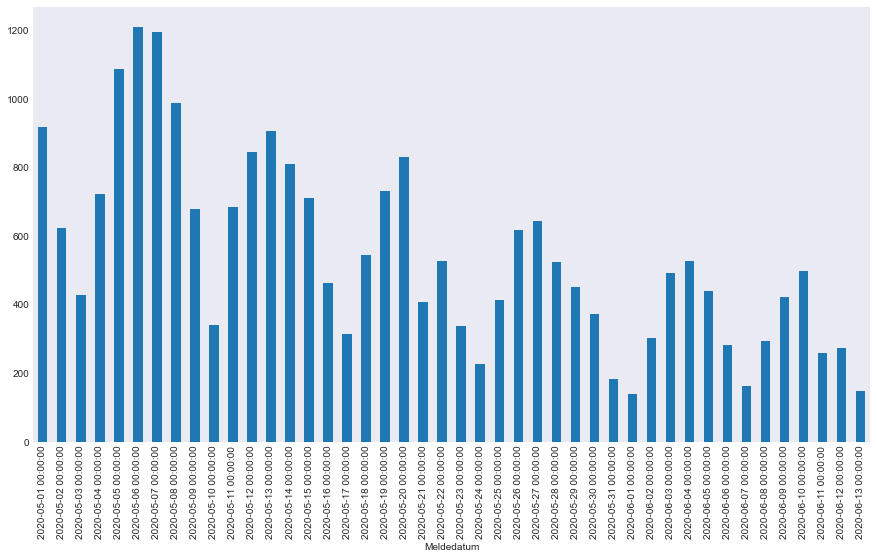

In [101]:
rki.NewCases['05-01-2020':].plot.bar()

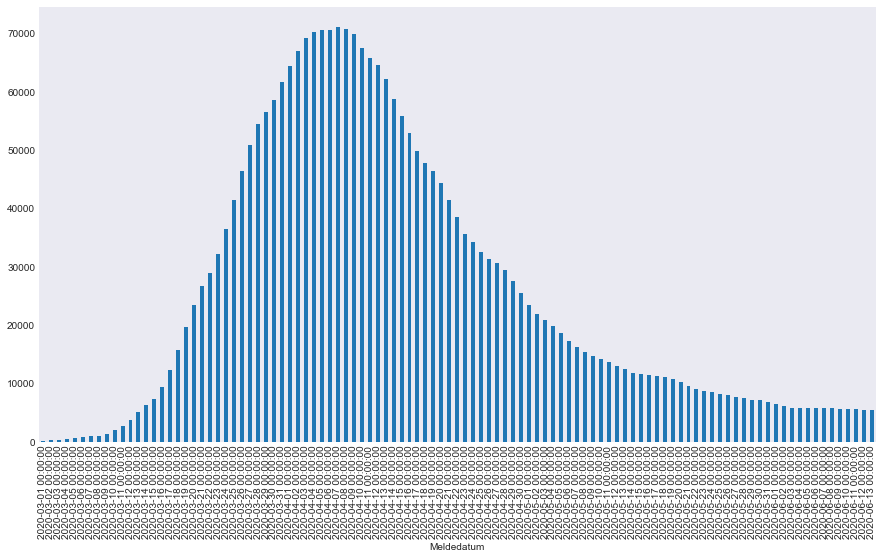

In [102]:
rki.ActiveCases['03-01-2020':].plot.bar()

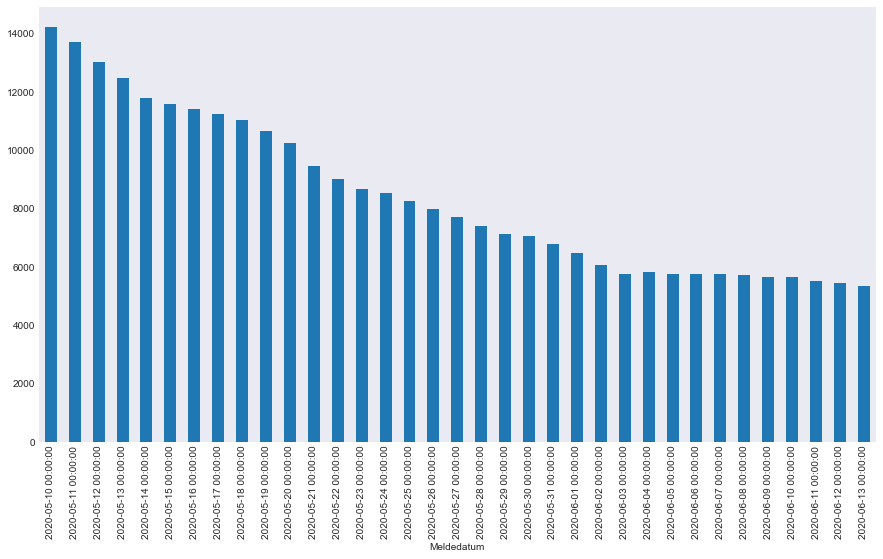

In [103]:
rki.ActiveCases['05-10-2020':].plot.bar()

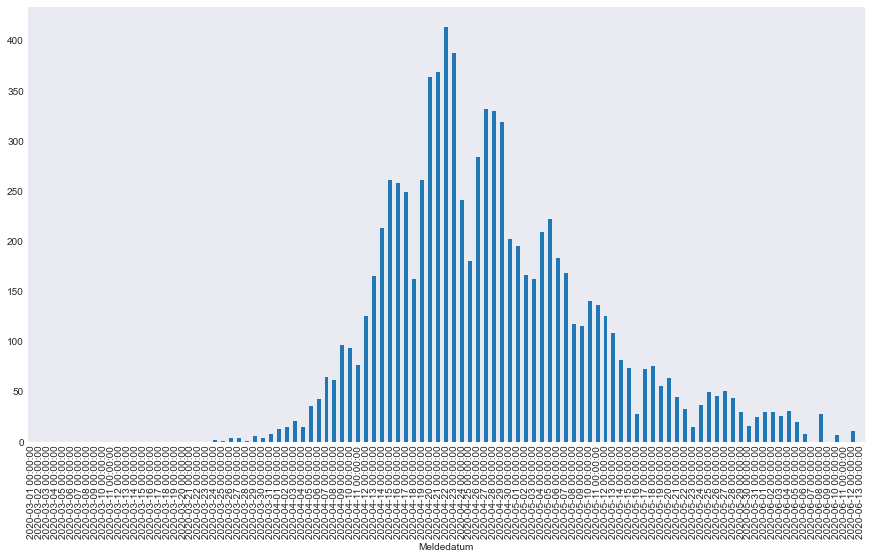

In [104]:
rki.NewDeath['03-01-2020':].plot.bar()

Text(0.5, 1.0, 'Growth Germany')

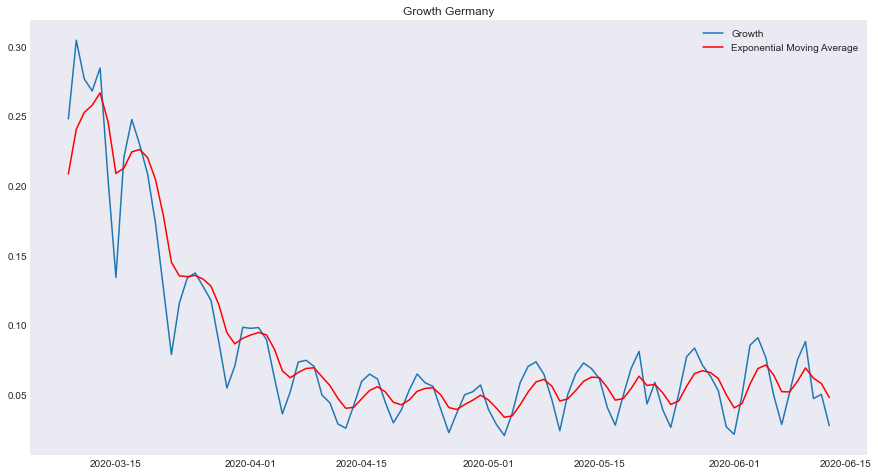

In [105]:
start_date = '03-09-2020'
x = rki[start_date:].index
plt.plot(x, rki.Growth[start_date:], label='Growth')
plt.plot(x, rki.Growth.ewm(span=5,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Germany')

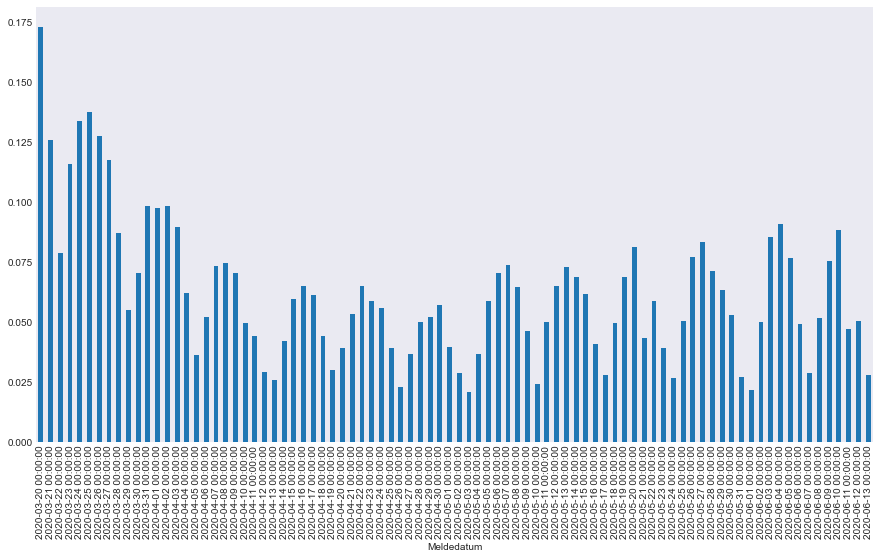

In [106]:
rki.Growth['03-20-2020':].plot.bar()

In [107]:
rki.tail(20)

,NewCases,NewDeathRKI,NewRecoveredRKI,NewRecovered,NewDeath,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,,,
2020-05-25,414,8.0,284,661.0,49.0,179249,8343.0,162672.0,8234.0,0.050279
2020-05-26,616,10.0,469,817.0,45.0,179865,8388.0,163489.0,7988.0,0.077116
2020-05-27,642,9.0,475,878.0,50.0,180507,8438.0,164367.0,7702.0,0.083355
2020-05-28,525,5.0,386,790.0,43.0,181032,8481.0,165157.0,7394.0,0.071004
2020-05-29,451,7.0,326,683.0,29.0,181483,8510.0,165840.0,7133.0,0.063227
2020-05-30,371,2.0,246,445.0,16.0,181854,8526.0,166285.0,7043.0,0.052676
2020-05-31,181,2.0,130,438.0,24.0,182035,8550.0,166723.0,6762.0,0.026767
2020-06-01,138,2.0,40,411.0,29.0,182173,8579.0,167134.0,6460.0,0.021362
2020-06-02,302,5.0,114,681.0,29.0,182475,8608.0,167815.0,6052.0,0.049901


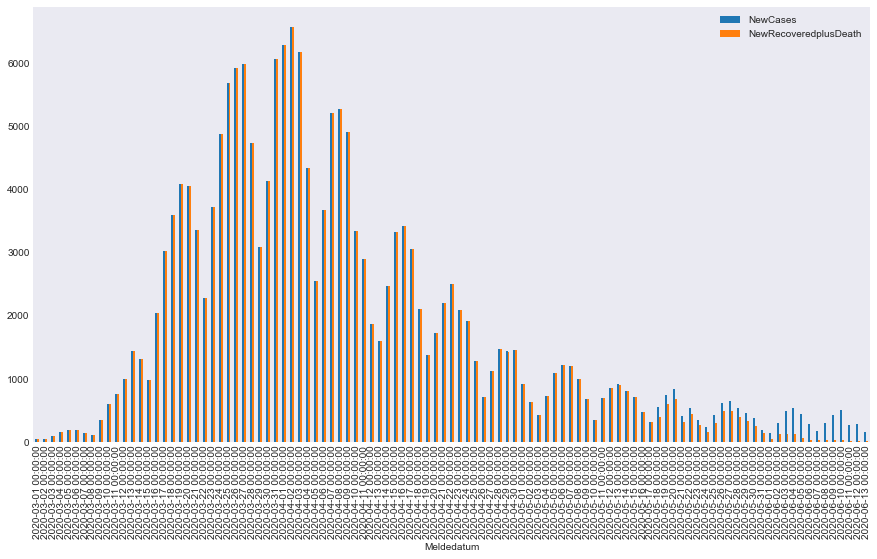

In [108]:
rki['NewRecoveredplusDeath'] = rki.NewRecoveredRKI + rki.NewDeathRKI
rki['03-01-2020':][['NewCases', 'NewRecoveredplusDeath']].plot.bar()
rki.drop('NewRecoveredplusDeath', axis=1, inplace=True)